# garbage_classifier

This notebook classifies website text snippets into useful or not (i.e., garbage) using transfer learning starting from an existing hugging face model
* Get a model checkpoint for an encoder model 
* Use reinforcement learning to apply the model on a new classification problem (EAGER website data) with limited new trained data
* Apply new head of model to full EAGER corpus to come up with mixes of models
* Metrics and model registered through a combination of comet.ml and tensorboard 

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Jul 16 00:19:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Install and import libraries

In [2]:
COMET_PROJECT_NAME = "eager-garbage-classifier"

In [3]:
# check environment
import sys
IN_COLAB = 'google.colab' in sys.modules
print (IN_COLAB)

True


In [6]:
# colab file system setup 
if IN_COLAB: 
    !git clone https://github.com/euphonic/EAGER.git
    !pwd
    !mkdir /content/logs

fatal: destination path 'EAGER' already exists and is not an empty directory.
/content
mkdir: cannot create directory ‘/content/logs’: File exists


In [7]:
# mount google drive if in colab
drive_path = '/content/drive/'

if IN_COLAB:  
    from google.colab import drive
    drive.mount(drive_path, force_remount=True)

Mounted at /content/drive/


In [7]:
# install huggingface and other modules if in colab
if IN_COLAB: 
    !pip install transformers
    !pip install datasets
    !pip install python-dotenv
    !pip install comet_ml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
from comet_ml import Experiment
from comet_ml.api import API
from dotenv import load_dotenv

# setup comet_ml experiment
if IN_COLAB: 
    # read env file from Google drive 
    env_file = drive_path + 'MyDrive/raaste-config/.env'
    comet_config_file = drive_path + 'MyDrive/raaste-config/.comet.config'
    load_dotenv(env_file)

In [9]:
# ml libraries
from transformers import pipeline, AutoTokenizer, TFAutoModelForSequenceClassification, DataCollatorWithPadding, \
  AutoConfig, TFBertForSequenceClassification
from datasets import Dataset
import datasets
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.model_selection import train_test_split
import pandas as pd

# other
import numpy as np
import gzip
import tarfile
import datetime
import os 

In [9]:
if IN_COLAB: 
    !pip uninstall -y comet_ml
    !pip install comet_ml

Found existing installation: comet-ml 3.31.6
Uninstalling comet-ml-3.31.6:
  Successfully uninstalled comet-ml-3.31.6
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached comet_ml-3.31.6-py2.py3-none-any.whl (372 kB)


In [10]:
# load tensorboard 
%load_ext tensorboard

## Garbage classifier
keep test == 1, discard == 0

In [11]:
# Same as before
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [12]:
firm_file_location = '/content/EAGER/data/modeling/garbage/garbage_classifier_input.csv'
input_df = pd.read_csv(firm_file_location)
print(input_df.shape)

(5624, 2)


In [13]:
# inspect duplicates manually 
dup_df = input_df[input_df.duplicated('sample_text', keep=False)]
tmp_out_dir = '/content/tmp/'
os.makedirs(tmp_out_dir, exist_ok=True)  
dup_df.to_csv(tmp_out_dir + '/dup_df.csv', ',')

In [14]:
# remove duplicates and nulls
non_dup_df = input_df[~input_df.duplicated('sample_text', keep="first")]
print (non_dup_df.shape) 
non_null_df = non_dup_df[~ non_dup_df['sample_text'].isnull() ]
print (non_null_df.shape)

(4740, 2)
(4740, 2)


In [15]:
dataset = Dataset.from_pandas(non_null_df, split='train')
dataset.cast_column("of_interest", datasets.Value('int8'))

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Dataset({
    features: ['sample_text', 'of_interest', '__index_level_0__'],
    num_rows: 4740
})

In [16]:
# 85% train, 15% test + validation
train_test_dataset = dataset.train_test_split(test_size=0.15)
# Split the 20% test + valid in half test, half valid
test_valid_dataset = train_test_dataset['test'].train_test_split(test_size=0.3)
# gather everyone if you want to have a single DatasetDict
train_test_valid_dataset = datasets.DatasetDict({
    'train': train_test_dataset['train'],
    'test': test_valid_dataset['test'],
    'valid': test_valid_dataset['train']})

In [17]:
train_test_valid_dataset

DatasetDict({
    train: Dataset({
        features: ['sample_text', 'of_interest', '__index_level_0__'],
        num_rows: 4029
    })
    test: Dataset({
        features: ['sample_text', 'of_interest', '__index_level_0__'],
        num_rows: 214
    })
    valid: Dataset({
        features: ['sample_text', 'of_interest', '__index_level_0__'],
        num_rows: 497
    })
})

In [18]:
def tokenize_function(x):
  return tokenizer(x["sample_text"], truncation=True, max_length=100)

In [19]:
tokenized_dataset = train_test_valid_dataset.map(tokenize_function, batched=True, batch_size=None)

Parameter 'function'=<function tokenize_function at 0x7f89dd954b00> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [20]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['sample_text', 'of_interest', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 4029
    })
    test: Dataset({
        features: ['sample_text', 'of_interest', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 214
    })
    valid: Dataset({
        features: ['sample_text', 'of_interest', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 497
    })
})

In [21]:
samples = tokenized_dataset["train"].to_dict()
samples = {k: v for k, v in samples.items() if k not in ["__index_level_0__", "sample_text"]}
for k, v in samples.items(): 
  print (k, v[0:5])

of_interest [0, 1, 0, 0, 0]
input_ids [[101, 5786, 6465, 2358, 1012, 1078, 1526, 100, 1526, 22735, 1010, 1078, 1526, 2821, 29655, 1526, 4008, 14142, 2620, 102], [101, 9871, 2592, 7300, 5310, 2177, 102], [101, 3976, 1024, 102], [101, 23661, 102], [101, 17917, 11124, 3351, 102]]
token_type_ids [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0], [0, 0, 0, 0, 0]]
attention_mask [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1], [1, 1, 1], [1, 1, 1, 1, 1]]


In [22]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding="max_length", max_length=100, return_tensors="tf")

In [23]:
batch = data_collator(samples)
{k: v.shape for k, v in batch.items()}

{'attention_mask': TensorShape([4029, 100]),
 'input_ids': TensorShape([4029, 100]),
 'of_interest': TensorShape([4029]),
 'token_type_ids': TensorShape([4029, 100])}

In [26]:
# config
config = AutoConfig.from_pretrained(checkpoint)
config.num_labels=1
config.hidden_dropout_prob = 0.2
config.attention_probs_dropout_prob = 0.2
config.hidden_size = 64
config.intermediate_size = 256
config.num_hidden_layers = 4
config.num_attention_heads = 4
print (type(config))

<class 'transformers.models.bert.configuration_bert.BertConfig'>


In [27]:
num_epochs = 50
batch_sizes = [8, 16, 32]
model_name = COMET_PROJECT_NAME.replace ('-', '_')

for bs in batch_sizes: 
  # read config file from git repo 
  experiment = Experiment(project_name=COMET_PROJECT_NAME)
  with experiment.train():
    experiment.log_parameter("batch_size", bs)

  # model
  model = TFAutoModelForSequenceClassification.from_config(config)
  print (type(model))

  print ('batch_size', bs)

  tf_train_dataset = tokenized_dataset["train"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols="of_interest",
    shuffle=True,
    collate_fn=data_collator,
    batch_size=bs,
  )

  tf_validation_dataset = tokenized_dataset["valid"].to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols="of_interest",
    shuffle=False,
    collate_fn=data_collator,
    batch_size=bs,
  )

  # The number of training steps is the number of samples in the dataset, divided by the batch size then multiplied
  # by the total number of epochs
  num_train_steps = len(tf_train_dataset) * num_epochs
  lr_scheduler = PolynomialDecay(
      initial_learning_rate=5e-5, end_learning_rate=0, decay_steps=num_train_steps
  )

  opt = Adam(learning_rate=lr_scheduler, beta_1=0.9, beta_2=0.999)

  log_dir = "/content/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)    

  early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

  loss = tf.keras.losses.BinaryFocalCrossentropy(from_logits=True, gamma=2.0, label_smoothing=0.2) # gamma = 0 is equivalent to binary cross entropy
  model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])

  model.fit(tf_train_dataset, validation_data=tf_validation_dataset, 
        epochs=num_epochs, callbacks=[tensorboard_callback, early_stopping_callback])
  
  # save model to disk -- can be added to for loop above

  model_save_path = '/content/models/' + model_name + "_" + str(bs)
  print (model_save_path)
  model.save_pretrained(model_save_path)
  experiment.log_model(name=model_name, file_or_folder=model_save_path)
  
  experiment.end()

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET ERROR: Failed to calculate active processors count. Fall back to default CPU count 1
COMET INFO: Experiment is live on comet.ml https://www.comet.com/euphonic/eager-garbage-classifier/b5d0b3e931dd49349a5da32c5e2107d0



<class 'transformers.models.bert.modeling_tf_bert.TFBertForSequenceClassification'>
batch_size 8


COMET WARNING: tensorflow datasets are not currently supported for gradient and activation auto-logging


Epoch 1/50
504/504 [==============================] - 27s 31ms/step - loss: 0.1394 - accuracy: 0.7029 - val_loss: 0.1115 - val_accuracy: 0.8390
Epoch 2/50
504/504 [==============================] - 14s 28ms/step - loss: 0.0999 - accuracy: 0.8439 - val_loss: 0.0956 - val_accuracy: 0.8350
Epoch 3/50
504/504 [==============================] - 14s 27ms/step - loss: 0.0811 - accuracy: 0.8781 - val_loss: 0.0943 - val_accuracy: 0.8793
Epoch 4/50
504/504 [==============================] - 14s 27ms/step - loss: 0.0634 - accuracy: 0.9188 - val_loss: 0.0980 - val_accuracy: 0.8753
Epoch 5/50
504/504 [==============================] - 14s 28ms/step - loss: 0.0481 - accuracy: 0.9402 - val_loss: 0.0978 - val_accuracy: 0.8773
Epoch 6/50
504/504 [==============================] - 14s 28ms/step - loss: 0.0387 - accuracy: 0.9561 - val_loss: 0.1351 - val_accuracy: 0.8592
Epoch 7/50
504/504 [==============================] - 14s 28ms/step - loss: 0.0314 - accuracy: 0.9690 - val_loss: 0.1423 - val_accuracy:

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/euphonic/eager-garbage-classifier/b5d0b3e931dd49349a5da32c5e2107d0
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     accuracy [13]                : (0.7029039263725281, 0.9880864024162292)
COMET INFO:     batch_accuracy [663]         : (0.25, 1.0)
COMET INFO:     batch_loss [663]             : (0.008528945036232471, 0.17399391531944275)
COMET INFO:     epoch_duration [13]          : (13.730163596999773, 26.830443551999906)
COMET INFO:     loss [13]                    : (0.017113028094172478, 0.13939005136489868)
COMET INFO:     val_accuracy [13]            : (0.8169013857841492, 0.8792756795883179)
COMET INFO:     val_loss [13]                : (0.09434492886066437, 0.2644665539264679)
COMET INFO:     validate_batch_accuracy [91] : (0.625

<class 'transformers.models.bert.modeling_tf_bert.TFBertForSequenceClassification'>
batch_size 16


COMET WARNING: tensorflow datasets are not currently supported for gradient and activation auto-logging


Epoch 1/50
252/252 [==============================] - 20s 38ms/step - loss: 0.1551 - accuracy: 0.6168 - val_loss: 0.1159 - val_accuracy: 0.8209
Epoch 2/50
252/252 [==============================] - 8s 31ms/step - loss: 0.1063 - accuracy: 0.8352 - val_loss: 0.1013 - val_accuracy: 0.8571
Epoch 3/50
252/252 [==============================] - 8s 30ms/step - loss: 0.0887 - accuracy: 0.8697 - val_loss: 0.0906 - val_accuracy: 0.8592
Epoch 4/50
252/252 [==============================] - 8s 30ms/step - loss: 0.0735 - accuracy: 0.8970 - val_loss: 0.0906 - val_accuracy: 0.8873
Epoch 5/50
252/252 [==============================] - 8s 33ms/step - loss: 0.0572 - accuracy: 0.9258 - val_loss: 0.0939 - val_accuracy: 0.8873
Epoch 6/50
252/252 [==============================] - 9s 34ms/step - loss: 0.0464 - accuracy: 0.9442 - val_loss: 0.0933 - val_accuracy: 0.8692
Epoch 7/50
252/252 [==============================] - 9s 34ms/step - loss: 0.0379 - accuracy: 0.9610 - val_loss: 0.1139 - val_accuracy: 0.879

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/euphonic/eager-garbage-classifier/3b4deb8fcb034236be1f78354219afff
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     accuracy [13]                : (0.6167783737182617, 0.9865971803665161)
COMET INFO:     batch_accuracy [338]         : (0.5, 1.0)
COMET INFO:     batch_loss [338]             : (0.008155182003974915, 0.1746785044670105)
COMET INFO:     epoch_duration [13]          : (7.506562565000422, 20.184901101999912)
COMET INFO:     loss [13]                    : (0.01767929457128048, 0.15513870120048523)
COMET INFO:     val_accuracy [13]            : (0.8209255337715149, 0.8873239159584045)
COMET INFO:     val_loss [13]                : (0.09058355540037155, 0.18001122772693634)
COMET INFO:     validate_batch_accuracy [52] : (0.8125, 

<class 'transformers.models.bert.modeling_tf_bert.TFBertForSequenceClassification'>
batch_size 32


COMET WARNING: tensorflow datasets are not currently supported for gradient and activation auto-logging


Epoch 1/50
126/126 [==============================] - 17s 51ms/step - loss: 0.1694 - accuracy: 0.5982 - val_loss: 0.1605 - val_accuracy: 0.6499
Epoch 2/50
126/126 [==============================] - 5s 38ms/step - loss: 0.1341 - accuracy: 0.6644 - val_loss: 0.1138 - val_accuracy: 0.8491
Epoch 3/50
126/126 [==============================] - 5s 38ms/step - loss: 0.1042 - accuracy: 0.8434 - val_loss: 0.1028 - val_accuracy: 0.8592
Epoch 4/50
126/126 [==============================] - 5s 39ms/step - loss: 0.0897 - accuracy: 0.8694 - val_loss: 0.0965 - val_accuracy: 0.8753
Epoch 5/50
126/126 [==============================] - 5s 38ms/step - loss: 0.0792 - accuracy: 0.8888 - val_loss: 0.0930 - val_accuracy: 0.8793
Epoch 6/50
126/126 [==============================] - 5s 37ms/step - loss: 0.0685 - accuracy: 0.9089 - val_loss: 0.0888 - val_accuracy: 0.8913
Epoch 7/50
126/126 [==============================] - 5s 37ms/step - loss: 0.0578 - accuracy: 0.9293 - val_loss: 0.0944 - val_accuracy: 0.885

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/euphonic/eager-garbage-classifier/24b396f51d7b40e2a3aa9753156442f5
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     accuracy [16]                : (0.5981633067131042, 0.9818813800811768)
COMET INFO:     batch_accuracy [208]         : (0.5625, 1.0)
COMET INFO:     batch_loss [208]             : (0.00978885032236576, 0.1745605766773224)
COMET INFO:     epoch_duration [16]          : (4.624099743999977, 17.35360582500016)
COMET INFO:     loss [16]                    : (0.02114485763013363, 0.16939465701580048)
COMET INFO:     val_accuracy [16]            : (0.649899423122406, 0.8993963599205017)
COMET INFO:     val_loss [16]                : (0.08880206197500229, 0.1605159044265747)
COMET INFO:     validate_batch_accuracy [32] : (0.6505681

## Register model

In [29]:
best_run = 'euphonic/' + COMET_PROJECT_NAME + '/daily_pilaster_8175'
version = "1.0.3"
api = API()
api_exp = api.get(best_run)
api_exp.register_model(model_name, version=version)

COMET INFO: Successfully registered 'eager-garbage-classifier', version '1.0.3' in workspace 'euphonic'


{'registryModelId': 'dyXSwgVHtuYcesXa63lRU7TUh',
 'registryModelItemId': 'h0YeXb5dKZA70vwTzd21qcp5K'}

## Make predictions
Write results out to file for manual DQ

In [12]:
best_run = 'euphonic/' + COMET_PROJECT_NAME + '/daily_pilaster_8175'
version = "1.0.3" # need to set manually for now
api = API()
api.download_registry_model("euphonic", COMET_PROJECT_NAME, version,
                            output_path="/content/registered_models/", expand=True)

COMET WARNING: COMET_INI is deprecated; use COMET_CONFIG
COMET INFO: Downloading registry model 'eager-garbage-classifier', version '1.0.3', stage None from workspace 'euphonic'...
COMET INFO: Unzipping model to '/content/registered_models' ...
COMET INFO: done!


In [25]:
# optional retrieve model from registry
local_model_dir = 'eager_garbage_classifier_32' # need to set manually for now
model = TFBertForSequenceClassification.from_pretrained ('/content/registered_models/' + local_model_dir)

Some layers from the model checkpoint at /content/registered_models/eager_garbage_classifier_32 were not used when initializing TFBertForSequenceClassification: ['dropout_83']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at /content/registered_models/eager_garbage_classifier_32.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [29]:
!pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement keras.backend (from versions: none)
ERROR: No matching distribution found for keras.backend


In [34]:
from keras.backend import set_session
from keras.backend import clear_session
from keras.backend import get_session
import tensorflow
import gc

# Reset Keras Session
def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    try:
        del classifier # this is from global space - change this as you need
    except:
        pass

    print(gc.collect()) # if it's done something you should see a number being outputted

    # use the same config as you used to create the session
    config = tensorflow.config
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tensorflow.Session(config=config))

reset_keras()

1414


AttributeError: ignored

In [21]:
# open file dir, read files and run predictions. aggregate results in a list object
company_file_dir = '/content/EAGER/data/orgs/parsed_page_output'
data_for_df = []
start, itr, batch_end = 0, 0, 50

for filename in os.listdir(company_file_dir):
  if filename.endswith('.txt'):
    with open( os.path.join(company_file_dir, filename) ) as file_h:
      co_text = [line for line in file_h]
      co_id = np.repeat (filename, len(co_text))
      co_index = np.arange (0, len(co_text))
      L = list(zip(co_id, co_index, co_text))
      data_for_df.append (L)
    itr += 1
    if (itr % batch_end == 0): 
      break

In [22]:
# transfer results to dataframe
dq_check_df = pd.DataFrame([t for lst in data_for_df for t in lst], columns = ['firm_name_txt', 'index', 'sample_text'])
dq_check_df

,firm_name_txt,index,sample_text
0,Wostec.txt,0,Home\n
1,Wostec.txt,1,About\n
2,Wostec.txt,2,Map To WESTEC\n
3,Wostec.txt,3,Administration of Justice\n
4,Wostec.txt,4,CORE\n
...,...,...,...
51159,Mattson Technology.txt,301,Constant vigilance by all to identify hazards ...
51160,Mattson Technology.txt,302,Meeting or exceeding all occupational health a...
51161,Mattson Technology.txt,303,Recognizing the contributions of our employees...
51162,Mattson Technology.txt,304,Compelling desire to always do better in the a...


In [23]:
all_sample_text = list(dq_check_df['sample_text'])

tokens = tokenizer(all_sample_text,  padding="max_length", max_length=100, truncation=True, return_tensors="tf")

In [26]:
output = model(**tokens)

logits = output.logits.numpy().flatten()
preds = tf.round(tf.nn.sigmoid(output.logits)).numpy().flatten()

ResourceExhaustedError: ignored

In [36]:
dq_check_df['logits'] = logits.tolist()
dq_check_df['preds'] = preds.tolist() 

In [37]:
# write to disk to review  manually 
dq_check_df.to_csv(tmp_out_dir + '/dq_check_df.csv', ',')

count    1770.000000
mean       -0.527774
std         1.942056
min        -2.158271
25%        -2.152323
50%        -2.070858
75%         2.017398
max         2.110805
dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


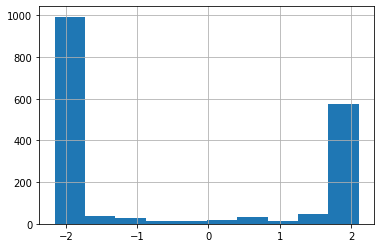

In [92]:
print (s_logit.describe())
print (s_logit.hist())

count    1770.000000
mean        0.385311
std         0.486806
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


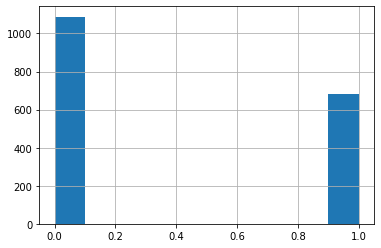

In [95]:
print (s_preds.describe())
print (s_preds.hist())